In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 4.3MB/s 
     |████████████████████████████████| 890kB 26.9MB/s 
     |████████████████████████████████| 2.9MB 29.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c72216bae37f5cd14825dd6c14cadaccffa37bfc4f7ddb22d2a5c6b302148a9a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import io

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/News_detection/train_test")
os.getcwd()
os.listdir()

['news_semitrain.csv',
 'news_semitest.csv',
 'news_semitest1.csv',
 'news_semitrain1.csv',
 'news_train.csv',
 'test_set.csv',
 'train_set.csv',
 'words.csv',
 'words1.csv',
 'test set.xlsx',
 'News_detection(kobert+extrapropre).h5']

In [ ]:
train = pd.read_csv("train_set.csv")
test = pd.read_csv("test_set.csv")

In [ ]:
train[0:20]

,n_id,date,title,content,ord,information
0,NEWS09611,20200113,서철모 화성시장 ‘묘수’..불법 주정차 해결,월 정기권을 폐지하자 장기 주차차량이 시범요금제 시행전 대비 평균 36% 감소했다,70,0
1,NEWS08586,20200507,[전일 주요 공시] SK이노베이션ㆍ현대차ㆍ하나투어 등,"피씨엘, 2184만 원 규모 진단키트 공급계약 체결",12,0
2,NEWS07112,20200611,플로이드 동생의 눈물호소 “흑인 가치가 20달러인가?”,정치테마 매집+거래량+핵심인맥 당장 줄상한가 가도 책임안집니다,70,1
3,NEWS09616,20200525,부고,최종목표 1000% 이상 함께 도전할 분 모집 여기 클릭,38,1
4,NEWS09008,20200102,"신승훈, 데뷔 30주년 기념 전국 투어 ‘미소속에 비친 그대’ 4월 11일 서울서 시작",똑똑해진 소비자..한국도 이젠 소형차 시대,85,1
5,NEWS02986,20200224,[김준형의 오토 인사이드] 코로나19와 맞서는 음압 구급차의 모든 것,가격은 얼마나 하나,36,0
6,NEWS05818,20200430,"""추천 인재 입사하면 2000만원 포상""…'구인전쟁' 벌어진 곳",추천한 인재가 최종 입사하면 추천인에게 2000만원의 포상금을 지급하는 업체까지 등...,5,0
7,NEWS08175,20200402,"코로나가 훑고간 증시, 판이 바뀌었다",당시는 금융위기가 정점을 찍은 후 코스피가 급등세를 보였던 시기다,129,0
8,NEWS07875,20200313,수원 임산부 마스크..통장이 직접 배부,염태영 수원시장이 임산부 마스크를 주민센터를 통해 배부하기로 결정했다고 13일 밝혔다,64,0
9,NEWS08760,20200610,"티맥스, 정부 긴급재난지원금 소프트웨어 지원",10%수익을 40%로 만들어 준다고.. 영웅스탁론이라면 가능~.효과적인 레버리지를 ...,27,1


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 4.3MB/s 


In [ ]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )


        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)


        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [ ]:
train['Review'] = (train['title'].map(str) +' '+ train['content']).apply(lambda row: row.strip())
test['Review'] = (test['title'].map(str) +' '+ test['content']).apply(lambda row: row.strip())

In [ ]:
#불러올 파일의 경로를 filename 변수에 저장
filename2 = '/content/gdrive/MyDrive/Colab Notebooks/News_detection/train_test/words1.csv'

#pandas read_csv로 불러오기
words = pd.read_csv(filename2)

In [ ]:
stopwords = words.word[2930:4144]
stopwords

2930    캠페인
2931     포함
2932     검토
2933     발생
2934     대표
       ... 
4108     방안
4109     인증
4110     주말
4111     주총
4112     향해
Name: word, Length: 1183, dtype: object

In [ ]:
l_1d = stopwords.values.tolist()
print(l_1d)

['캠페인', '포함', '검토', '발생', '대표', '넘어', '업체', '하면', '이사', '충북', '해야', '동반', '2010년', '52주신고가를', '5년간', 'CES', '개의', '개정', '검찰에', '경고했다', '공개한', '공천', '관내', '그가', '기간에', '기능이', '기반을', '기업으로', '긴', '끝에', '남아', '노하우를', '느낄', '능력을', '단위', '단체', '당국은', '대기업', '대부분의', '대표의', '매장에서', '면밀히', '못할', '미니', '미만', '바란다"고', '번째로', '베이징', '별', '부총리는', '불법', '삼성전자가', '상장폐지', '서울=연합인포맥스', '서울에서', '선보였다', '세계적', '소송을', '소프트웨어', '실내', '않다고', '앱을', '언급한', '업체가', '연준이', '오랜', '우려를', '위험을', '유명한', '이하로', '일부를', '임원주요주주', '입은', '있어야', '점검하고', '조정을', '주간', '주류', '주문', '주체로', '줄이기', '증가로', '증가해', '추', '추후', '충격을', '크지', '투표', '프로젝트를', '했던', '헬스케어', '형태의', '확대로', '환경이', '회사가', '접수', '6개', '코로나19에', '이용', '피해', '러시아', '앱', '찾는', '의약품', '50대', '개발해', '곳이다', '관리에', '교육부', '구는', '구축하고', '급여', '기념해', '기록을', '깊은', '나아가', '늘려', '다하겠다고', '달라고', '대응에', '되길', '따로', '문제로', '문제에', '변화가', '보낸', '사건을', '설', '소개했다', '속보', '승인을', '입주', '자리', '주식수는', '준비를', '지배구조', '집단', '측이', '펀드는', '평소', '하다', '화상', '1만', '타다', '중단', '집값', '방문'

In [ ]:
pattern = '|'.join(l_1d)
print(pattern)

캠페인|포함|검토|발생|대표|넘어|업체|하면|이사|충북|해야|동반|2010년|52주신고가를|5년간|CES|개의|개정|검찰에|경고했다|공개한|공천|관내|그가|기간에|기능이|기반을|기업으로|긴|끝에|남아|노하우를|느낄|능력을|단위|단체|당국은|대기업|대부분의|대표의|매장에서|면밀히|못할|미니|미만|바란다"고|번째로|베이징|별|부총리는|불법|삼성전자가|상장폐지|서울=연합인포맥스|서울에서|선보였다|세계적|소송을|소프트웨어|실내|않다고|앱을|언급한|업체가|연준이|오랜|우려를|위험을|유명한|이하로|일부를|임원주요주주|입은|있어야|점검하고|조정을|주간|주류|주문|주체로|줄이기|증가로|증가해|추|추후|충격을|크지|투표|프로젝트를|했던|헬스케어|형태의|확대로|환경이|회사가|접수|6개|코로나19에|이용|피해|러시아|앱|찾는|의약품|50대|개발해|곳이다|관리에|교육부|구는|구축하고|급여|기념해|기록을|깊은|나아가|늘려|다하겠다고|달라고|대응에|되길|따로|문제로|문제에|변화가|보낸|사건을|설|소개했다|속보|승인을|입주|자리|주식수는|준비를|지배구조|집단|측이|펀드는|평소|하다|화상|1만|타다|중단|집값|방문|정책|20대|되고|대만|평가|블록체인|0%대|000님|96530|1000만원|10만|10억|10초면|13만|1개|1개월안에|1위는|200명|2020年|2020년은|2곳|2번째|31번째|32번째|3상|3일안에|3천원대|40대|4개월|4차산업|5000억원|500억|50원|52주|53세|6月|6억|7세대|7인의|8조|AIB-CTS"를|DB금융투자|Fed|GV80|ITBC스탁의|LNG선|OLED|OOO|PLUS|R&amp;D|RFHIC|SK브로드밴드|SK텔레콤|SK하이닉스와|SUV|TOP1|TOP5|中위안화고시환율|故|日정부|英|가속화|가입비|가입비가|가입을|간담회|간호사|감사|감소세|갓갓|강경화|개막|개인투자자를|개장즉시|거래소|거짓말|걱정|건조기|검찰총장|견본주택|결혼|경남바이오파마|경신|경쟁률|계좌에|고수는|고용보험|공략합니다|공무원|공적마스크|공포에|과기부|관련기사|관련주에|교

In [ ]:
train['Review'] = train['Review'].str.replace(pattern, '')
train['Review']

0        서철모 화성시  ‘묘수’.. 주정 결 월 정기권을 폐지하자 기 주량이 시범요금 전 ...
1             [전일 주요 ] SK이노베이션ㆍㆍ투어 등 , 2184만 원 규모  공급계약 체결
2        플로이드 동생의 눈물호소 “흑인 가 20러인가?” 테마 +거래량+핵심인맥  줄상한가...
3                           부고 최종 1000% 이상 함께 할 분 모  여기 클릭
4        신승훈, 데뷔 30주년  전국 투어 ‘미소속에 비친 그’  4월 11일 서울서 시작...
                               ...                        
94991    [신털기] '팝콘 팡팡' 벨로스터 N…런치컨트롤 '슝' 다만 서킷 주행에 필수인 동...
94992    '코로19'로 도는 산업용 전기…여유전력 비율   최고 전체 발전비 용량(12만58...
94993    잠실 스포츠·MICE 발 화…민자 격성 조사 통과 2022년  착공주변지역 투기 단 도 
94994    그린카, 브랜드  김민아 발탁 앞으로 배우 여진구와 방송인 김민아 두 브랜드 은 합...
94995    '이엠텍' 10% 이상 상승, 단기·중기 이평선 정배열로 상승세 이 기사는 한신문과...
Name: Review, Length: 94996, dtype: object

In [ ]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 64 
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True)
       
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        segment = [0]*SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        targets.append(data_df[LABEL_COLUMN][i])

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 20
DATA_COLUMN = "Review"
LABEL_COLUMN = "information"

In [ ]:
train_x, train_y = load_data(train)

  0%|          | 0/94996 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 94996/94996 [00:24<00:00, 3902.45it/s]


In [ ]:
test_x, test_y = load_data(test)

  0%|          | 0/23749 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 23749/23749 [00:06<00:00, 3599.27it/s]


In [ ]:
def create_classification_bert():
  model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  classification_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  classification_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], classification_first)
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1.0e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.FalsePositives(name='FalsePositive'), 'accuracy'])
  return classification_model

In [ ]:
classification_model = create_classification_bert()

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
classification_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]     

In [ ]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

In [ ]:
hist = classification_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=20, validation_data=(test_x, test_y))

Epoch 1/4
4750/4750 [==============================] - 889s 187ms/step - loss: 0.0694 - precision: 0.9694 - FalsePositive: 1146.0000 - accuracy: 0.9743 - val_loss: 0.0538 - val_precision: 0.9949 - val_FalsePositive: 46.0000 - val_accuracy: 0.9794
Epoch 2/4
4750/4750 [==============================] - 883s 186ms/step - loss: 0.0275 - precision: 0.9877 - FalsePositive: 460.0000 - accuracy: 0.9901 - val_loss: 0.0517 - val_precision: 0.9798 - val_FalsePositive: 192.0000 - val_accuracy: 0.9880
Epoch 3/4
4750/4750 [==============================] - 879s 185ms/step - loss: 0.0157 - precision: 0.9941 - FalsePositive: 223.0000 - accuracy: 0.9948 - val_loss: 0.0377 - val_precision: 0.9916 - val_FalsePositive: 78.0000 - val_accuracy: 0.9904
Epoch 4/4
4750/4750 [==============================] - 876s 184ms/step - loss: 0.0100 - precision: 0.9960 - FalsePositive: 150.0000 - accuracy: 0.9967 - val_loss: 0.0312 - val_precision: 0.9880 - val_FalsePositive: 113.0000 - val_accuracy: 0.9915


In [ ]:
print(hist.history['loss'])
print(hist.history['accuracy']) 
print(hist.history['precision'])

[0.06942237913608551, 0.027543945237994194, 0.01568845845758915, 0.010029206052422523]
[0.9743462800979614, 0.9900522232055664, 0.994799792766571, 0.9967367053031921]
[0.9693590998649597, 0.9877402186393738, 0.9940530061721802, 0.9960038065910339]


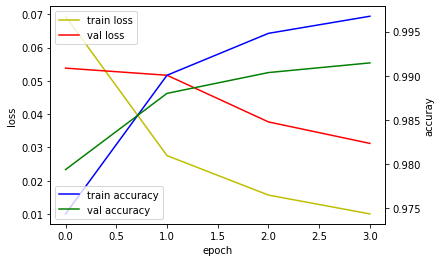

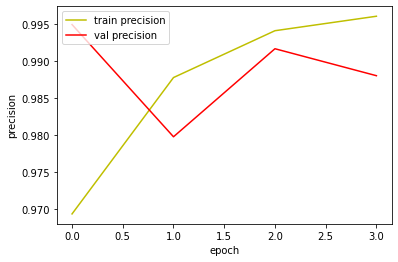

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

####################################
fig, prec_ax = plt.subplots()

prec_ax.plot(hist.history['precision'], 'y', label='train precision')
prec_ax.plot(hist.history['val_precision'], 'r', label='val precision')

prec_ax.set_xlabel('epoch')
prec_ax.set_ylabel('precision')

prec_ax.legend(loc='upper left')

plt.show()

In [ ]:
path = "/content/gdrive/My Drive/Colab Notebooks/News_detection"

In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/News_detection/train_test'

In [ ]:
classification_model.save_weights(path+"/News_detection(kobert+extrapropre).h5")

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def information_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = classification_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(정보가 있을 확률 : %.2f) 정보가 있는 문장입니다." % (1-predict_value))
    elif predict_answer == 1:
      print("(정보가 없을 확률 : %.2f) 정보가 없는 문장입니다." % predict_value)